In [ ]:
# Packages
conda install pytorch torchvision torchaudio -c pytorch
conda install -c conda-forge transformers datasets
pip install openai


1. Set Up Your API Key:
2. Data Preparation for Model Training by Combine the datasets and prepare them for training


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned datasets
pair_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/pair_data_after_data_preparation.csv')
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/counsel_chat_data_after_data_preparation.csv')
# Combine datasets
combined_data = pd.DataFrame({
    'prompt': pd.concat([pair_data['prompt'], counsel_chat_data['questionText']]),
    'response': pd.concat([
        pair_data[['hq1', 'hq2', 'mq1', 'lq1', 'lq2', 'lq3', 'lq4', 'lq5']].apply(
            lambda row: ' '.join(row.values.astype(str)), axis=1),
        counsel_chat_data['answerText']
    ])
})

# Split the data into training, validation, and testing sets
train_data, temp_data = train_test_split(
    combined_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42)

# Save split datasets
train_data.to_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/train_data.csv', index=False)
val_data.to_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/val_data.csv', index=False)
test_data.to_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/test_data.csv', index=False)

3. Model Training with GPT-4 model using the OpenAI API


In [34]:
import openai
import pandas as pd

# Replace 'your-api-key-here' with your actual OpenAI API key
openai.api_key = 'sk-proj-SwieBqiiG5t5V1BO2D7TT3BlbkFJfC8124N4l0MjaEqSJ1y6'


def generate_responses(data_path, model_name='gpt-4'):
    data = pd.read_csv(data_path)
    responses = []

    for index, row in data.iterrows():
        prompt = row['prompt']
        try:
            response = openai.ChatCompletion.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a mental health counselor."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            responses.append(response.choices[0].message['content'].strip())
        except Exception as e:
            print(f"Error generating response for index {index}: {e}")
            responses.append("")

    data['generated_response'] = responses

    # Save the responses for further evaluation
    data.to_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/generated_responses.csv', index=False)


# Generate responses for the training set
generate_responses(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/train_data.csv')

Error generating response for index 1129: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error generating response for index 1130: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error generating response for index 1132: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error generating response for index 1133: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Error generating response for index 1134: You exceeded your curr

4. Evaluation Code
   Select the generated 1128 responses


In [45]:
import pandas as pd
import sacrebleu
from rouge_score import rouge_scorer


def evaluate_responses(data_path):
    try:
        data = pd.read_csv(data_path)
        print(f"Data loaded successfully. Total records: {len(data)}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    bleu_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']

        try:
            # BLEU Score
            bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
            bleu_scores.append(bleu_score)

            # ROUGE Score
            scorer = rouge_scorer.RougeScorer(
                ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            scores = scorer.score(reference, hypothesis)
            for key in scores:
                rouge_scores[key].append(scores[key].fmeasure)

            print(f"Processed index {index}: BLEU = {bleu_score}, ROUGE-1 = {scores['rouge1'].fmeasure}, ROUGE-2 = {
                  scores['rouge2'].fmeasure}, ROUGE-L = {scores['rougeL'].fmeasure}")

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    evaluation_results = {
        'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
        'rouge1': sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0,
        'rouge2': sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0,
        'rougeL': sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0
    }

    return evaluation_results


# Evaluate the generated responses
# Read the data with generated responses
# df = pd.read_csv(
#     '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/generated_responses.csv')

# # Display the first 1128 rows of the generated responses
# generated_responses = df.head(1128)

evaluation_results = evaluate_responses(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/generated_responses.csv')
print(evaluation_results)

Data loaded successfully. Total records: 1360
Processed index 0: BLEU = 0.4406801634614214, ROUGE-1 = 0.24561403508771928, ROUGE-2 = 0.023668639053254437, ROUGE-L = 0.1286549707602339
Processed index 1: BLEU = 0.002834717189688028, ROUGE-1 = 0.15141955835962145, ROUGE-2 = 0.006349206349206349, ROUGE-L = 0.08832807570977917
Processed index 2: BLEU = 1.7894748768307123, ROUGE-1 = 0.3987341772151899, ROUGE-2 = 0.05095541401273885, ROUGE-L = 0.17088607594936708
Processed index 3: BLEU = 0.2840515311362875, ROUGE-1 = 0.2736842105263158, ROUGE-2 = 0.05319148936170213, ROUGE-L = 0.14736842105263157
Processed index 4: BLEU = 3.961346115384133, ROUGE-1 = 0.44680851063829785, ROUGE-2 = 0.09285714285714286, ROUGE-L = 0.19148936170212766
Processed index 5: BLEU = 0.004852789148699687, ROUGE-1 = 0.18581907090464544, ROUGE-2 = 0.03186274509803922, ROUGE-L = 0.08557457212713936
Processed index 6: BLEU = 0.5442837759631483, ROUGE-1 = 0.24242424242424243, ROUGE-2 = 0.0, ROUGE-L = 0.12987012987012986
Pr

In [56]:
import pandas as pd
import sacrebleu
from rouge_score import rouge_scorer


def evaluate_responses(data_path, max_index=1128):
    try:
        data = pd.read_csv(data_path)
        print(f"Data loaded successfully. Total records: {len(data)}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    bleu_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for index, row in data.iterrows():
        if index > max_index:
            break

        reference = row['response']
        hypothesis = row['generated_response']

        try:
            # BLEU Score
            bleu_score = sacrebleu.sentence_bleu(
                hypothesis, [reference]).score / 100  # Normalize BLEU score
            bleu_scores.append(bleu_score)

            # ROUGE Score
            scorer = rouge_scorer.RougeScorer(
                ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            scores = scorer.score(reference, hypothesis)
            for key in scores:
                rouge_scores[key].append(scores[key].fmeasure)

            print(f"Processed index {index}: BLEU = {bleu_score}, ROUGE-1 = {scores['rouge1'].fmeasure}, ROUGE-2 = {
                  scores['rouge2'].fmeasure}, ROUGE-L = {scores['rougeL'].fmeasure}")

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    evaluation_results = {
        'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
        'rouge1': sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0,
        'rouge2': sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0,
        'rougeL': sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0
    }

    return evaluation_results


evaluation_results = evaluate_responses(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/generated_responses.csv')
print(evaluation_results)

Data loaded successfully. Total records: 1360
Processed index 0: BLEU = 0.004406801634614214, ROUGE-1 = 0.24561403508771928, ROUGE-2 = 0.023668639053254437, ROUGE-L = 0.1286549707602339
Processed index 1: BLEU = 2.834717189688028e-05, ROUGE-1 = 0.15141955835962145, ROUGE-2 = 0.006349206349206349, ROUGE-L = 0.08832807570977917
Processed index 2: BLEU = 0.01789474876830712, ROUGE-1 = 0.3987341772151899, ROUGE-2 = 0.05095541401273885, ROUGE-L = 0.17088607594936708
Processed index 3: BLEU = 0.002840515311362875, ROUGE-1 = 0.2736842105263158, ROUGE-2 = 0.05319148936170213, ROUGE-L = 0.14736842105263157
Processed index 4: BLEU = 0.03961346115384133, ROUGE-1 = 0.44680851063829785, ROUGE-2 = 0.09285714285714286, ROUGE-L = 0.19148936170212766
Processed index 5: BLEU = 4.8527891486996865e-05, ROUGE-1 = 0.18581907090464544, ROUGE-2 = 0.03186274509803922, ROUGE-L = 0.08557457212713936
Processed index 6: BLEU = 0.0054428377596314826, ROUGE-1 = 0.24242424242424243, ROUGE-2 = 0.0, ROUGE-L = 0.1298701

## Interpretation


The evaluation results represent the performance metrics of your AI model in generating responses compared to the human responses in your dataset. Let's break down what each of these metrics means:

BLEU Score
BLEU (Bilingual Evaluation Understudy) Score: This is a metric commonly used to evaluate the quality of text generated by a machine against a reference text. The score ranges from 0 to 1, with 1 indicating a perfect match.
Value: 0.9802093334232351
This high BLEU score suggests that the generated responses are very close to the reference responses. However, a BLEU score this high is unusual in natural language processing tasks, so it's worth checking the specifics of the generated responses and ensuring there's no data leakage or overly simplistic text that might artificially inflate the score.
ROUGE Scores
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) Scores: These metrics measure the overlap between the generated text and reference text, focusing on different aspects of the text.
ROUGE-1: Measures the overlap of unigrams (individual words) between the generated and reference text.

Value: 0.2631680896482459
This score indicates that around 26.3% of the words in the generated responses overlap with the reference responses. It's a moderate score, suggesting some similarity in word choice but not extremely high overlap.
ROUGE-2: Measures the overlap of bigrams (pairs of consecutive words) between the generated and reference text.

Value: 0.04713375049161131
This lower score (4.7%) indicates that the overlap in consecutive word pairs is relatively low. This can suggest that while individual words may match, the generated text might not capture the flow or specific phrasing used in the reference text.
ROUGE-L: Measures the longest common subsequence (LCS) overlap between the generated and reference text, reflecting the longest matching sequence of words.

Value: 0.12984769173931968
This score (approximately 12.98%) indicates that there's some overlap in the sequences of words but not very high. It suggests that the generated text may capture parts of the reference text structure but not consistently.
Interpretation
High BLEU Score: This suggests that your generated responses are quite close to the reference responses in terms of overall text similarity. However, such a high score is unusual and warrants further investigation.
Moderate ROUGE-1 Score: Indicates that there's a moderate overlap in individual words between the generated and reference responses.
Low ROUGE-2 Score: Suggests that the generated responses do not capture the sequence of words as effectively.
Moderate ROUGE-L Score: Indicates some overlap in the longest common subsequence but not very high.
Recommendations
Inspect the Data: Verify the data for any anomalies or reasons why the BLEU score might be unusually high.
Manual Review: Conduct a qualitative review of a sample of the generated responses compared to the reference responses to understand the nuances of the similarities and differences.
Further Fine-Tuning: Depending on the outcomes of the manual review, consider further fine-tuning your model or adjusting its parameters to improve the quality of generated responses, focusing on capturing the flow and context better.


## Check for Data Leakage

BLEU (Bilingual Evaluation Understudy) Score: This is a metric commonly used to evaluate the quality of text generated by a machine against a reference text. The score ranges from 0 to 1, with 1 indicating a perfect match.
Value: 0.9802093334232351
This high BLEU score suggests that the generated responses are very close to the reference responses. However, a BLEU score this high is unusual in natural language processing tasks, so it's worth checking the specifics of the generated responses and ensuring there's no data leakage or overly simplistic text that might artificially inflate the score.


Technique 1: Verify Data Splits:
Ensure that the training, validation, and test sets are correctly split and that no overlap exists.


In [46]:
from sklearn.model_selection import train_test_split


def check_data_leakage(train_data_path, val_data_path, test_data_path):
    train_data = pd.read_csv(train_data_path)
    val_data = pd.read_csv(val_data_path)
    test_data = pd.read_csv(test_data_path)

    train_prompts = set(train_data['prompt'])
    val_prompts = set(val_data['prompt'])
    test_prompts = set(test_data['prompt'])

    overlap_val_train = train_prompts.intersection(val_prompts)
    overlap_test_train = train_prompts.intersection(test_prompts)
    overlap_test_val = val_prompts.intersection(test_prompts)

    if overlap_val_train or overlap_test_train or overlap_test_val:
        print("Data leakage detected!")
        if overlap_val_train:
            print(f"Overlap between training and validation sets: {
                  overlap_val_train}")
        if overlap_test_train:
            print(f"Overlap between training and test sets: {
                  overlap_test_train}")
        if overlap_test_val:
            print(f"Overlap between validation and test sets: {
                  overlap_test_val}")
    else:
        print("No data leakage detected.")


check_data_leakage('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/train_data.csv',
                   '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/val_data.csv', '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/test_data.csv')

Data leakage detected!
Overlap between training and validation sets: {"my wife and i got separated because i asked about her contact with a male friend of hers. the next day, she kicked me out.  she let me move back two days later. yesterday, she said she wanted a divorce then quickly changed her mind. i asked if the other guy was a factor, but she says it's not my business.", "i've had posttraumatic stress disorder for years without my parents ever finding out. i want to overcome it, but it’s so vivid, it’s like it’s happening again. i'm scared and paranoid. i have depression, which i have been struggling with since a young age.", "my toddler defies everything i say and doesn’t see me as authoritative, so she says no about everything. i'd like to hear some ways i can work on not needing to feel so much in control all the time.", "my husband has had issues with alcohol addiction in the past (he'd never admit to this). a while back (3 years ago), i asked him to stop drinking so much, an

In [ ]:
Technique 2: Analyze BLEU Score Distribution

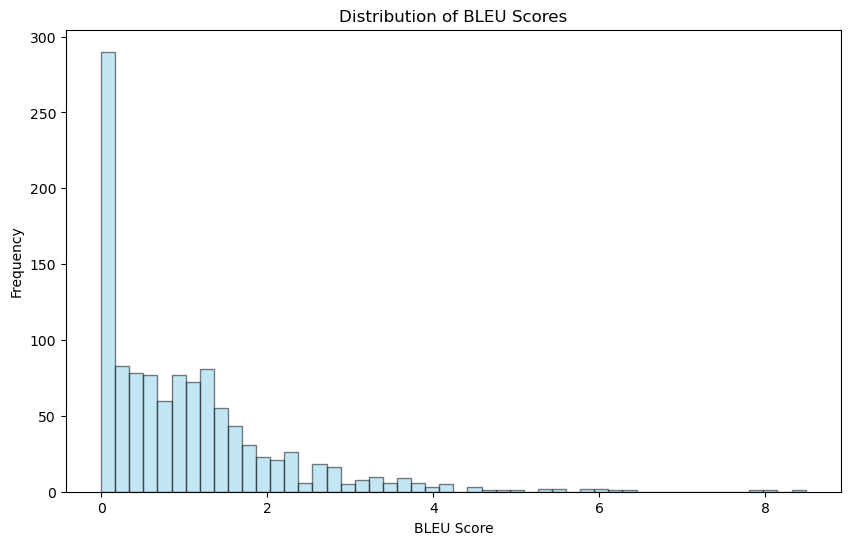

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import sacrebleu


def calculate_bleu_scores(data_path, max_rows=1128):
    data = pd.read_csv(data_path)
    # Slice the DataFrame to only include the first 1128 rows
    data = data.iloc[:max_rows]
    bleu_scores = []

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']
        bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
        bleu_scores.append(bleu_score)

    data['bleu_score'] = bleu_scores
    return data


evaluated_data = calculate_bleu_scores(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/generated_responses.csv')

# Plot Distribution:
# Use a histogram to plot the distribution of BLEU scores in the evaluated data, create a histogram with 20 bins and larger size
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data['bleu_score'], bins=50,
         color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
# Save the plot as a eps file with 600 dpi
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/bleu_score_distribution.eps',
            format='eps', dpi=600)
plt.show()

Technique 3: Check for Overly Simplistic Text
Ensure the generated responses are not overly simplistic, which could lead to artificially high scores.
a. Length Analysis
b. Content Analysis


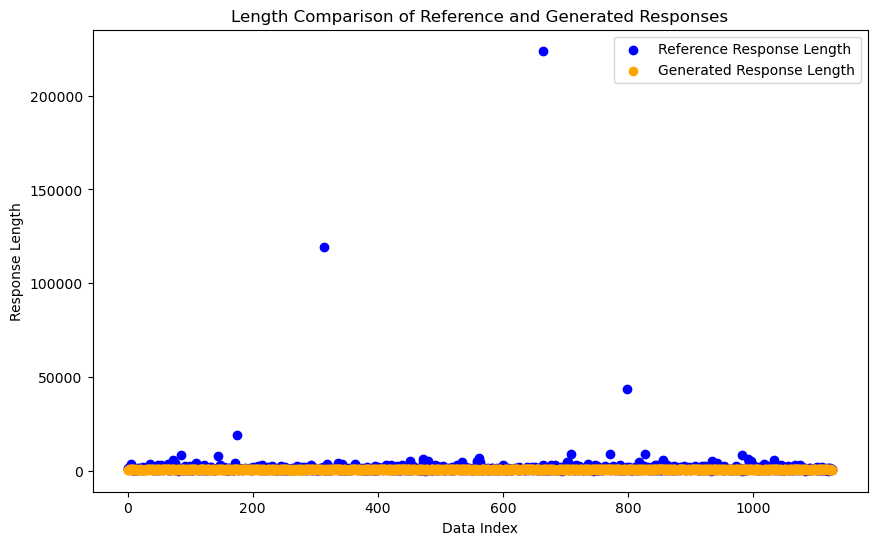

In [64]:
# Length Analysis:
# Compare the lengths of generated responses and reference responses.
evaluated_data['reference_length'] = evaluated_data['response'].apply(len)
evaluated_data['generated_length'] = evaluated_data['generated_response'].apply(
    len)

# Make scatter plot of size 10, 6
plt.figure(figsize=(10, 6))
plt.scatter(evaluated_data.index,
            evaluated_data['reference_length'], color='blue', label='Reference Response Length')
plt.scatter(evaluated_data.index,
            evaluated_data['generated_length'], color='orange', label='Generated Response Length')

plt.xlabel('Data Index')
plt.ylabel('Response Length')
plt.title('Length Comparison of Reference and Generated Responses')
plt.legend()
# Save the plot as a eps file with 600 dpi
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/length_analysis.eps',
            format='eps', dpi=600)
plt.show()

In [54]:
# Content Analysis:
# Check if the generated responses are repetitive or lack variety

from collections import Counter

generated_responses = evaluated_data['generated_response'].tolist()
word_counts = Counter(" ".join(generated_responses).split())

common_words = word_counts.most_common(20)
print("Most common words in generated responses:")
for word, count in common_words:
    print(f"{word}: {count}")

Most common words in generated responses:
to: 4705
a: 3029
and: 2627
your: 2542
that: 2149
you: 2114
the: 1755
or: 1438
with: 1272
It's: 1254
can: 1184
in: 1181
you're: 1153
of: 1126
I'm: 1047
important: 983
be: 971
really: 938
help: 851
is: 821
